In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
path = '/Users/jiachenyao/Desktop/Thesis/OpenFace_data/All_data_intensity_2/'

In [3]:
# Load data and extract features
dfs = []
num_deleted = 0

max_rows = 0
max_file = None

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        df = pd.read_csv(filepath)
        


        # Check the ratio of rows with confidence >= 0.98 to the total number of rows
        if len(df)>320 or len(df[df["confidence"]<0.98])/len(df) >= 0.15:
            # print the filename and delete the df variable
            #print(filename)
            del df
            num_deleted += 1
        else:
            # Select confidence >= 0.98 & success = 1
            df = df.loc[(df["confidence"]>= 0.98) & (df["success"]== 1 ) ] 
            # Drop columns that does not contain facial feature information
            df = df.drop(columns=["confidence","success","frame", "face_id", "timestamp"])
            
            # Drop binary AU features
            cols_to_drop = df.filter(regex='AU.*_c').columns
            df = df.drop(columns=cols_to_drop)

            # Feature selection
            # 115 features, excluding 3D and eye
            #df = df.iloc[:, np.concatenate([range(0, 8), range(288,294),range(299,306),range(311,321),range(325,330),
                                            #range(342,362),range(367,374),range(379,389),range(393,398),
                                            #range(410,430),range(674,691)])]

            
            # only mouth-100 features
            #df = df.iloc[:, np.concatenate([range(342,362), range(410,430),range(478,498),range(546,566),range(614,634)])]
            
            # eye_lmk: 0-7, 28-35 眼珠子外圈
            # eye brow: 17-26
            # mouth: 48-67
            # 230 features
            df = df.iloc[:, np.concatenate([range(8,16), range(36,44),range(64,72),range(92,100),range(120,128),range(148,156),
                                            
                                            range(176,184),range(204,212),range(232,240),range(262,270), 
                                            
                                            range(311,321),range(379,389),range(447,457),range(515,525),range(583,593), # eye brow: 17-26
                                            
                                            range(342,362), range(410,430),range(478,498),range(546,566),range(614,634)])] ## mouth: 48-67
            
            # above all + 脸颊


            df = df.fillna(method='ffill') # Forward fill missing values
            df = df.fillna(method='bfill') # Backward fill missing values

            # Add a column to indicate the emotion
            df.insert(0, 'emotion', os.path.splitext(os.path.basename(filepath))[0])
            # Exclude actor id
            df['emotion'] = df['emotion'].str.split('_', n=1, expand=True)[1]
            
            
            num_rows = df.shape[0]
            if num_rows > max_rows:
                max_rows = num_rows
                max_file = filename
            
            dfs.append(df)
        
print(f"{num_deleted} dataframes were deleted.")
print(len(dfs))

# Print file with maximum number of rows
print("File with maximum rows:", max_file)
print("Number of rows:", max_rows)

266 dataframes were deleted.
905
File with maximum rows: A205_mix_disg_sad_3070.csv
Number of rows: 299


In [4]:
for df in dfs:
    df['emotion'] = df['emotion'].apply(lambda x: x.split('_')[0] if not x.startswith('mix') else '_'.join(x.split('_')[:-1]))

In [5]:
# emotion pair
emo_pair_dfs = []

for df in dfs:
    #print(df.loc[0, "emotion"])
    if df.iloc[0]["emotion"] in ['sad', 'hap','mix_hap_sad'] :
        emo_pair_dfs.append(df)

In [6]:
emo_pair_max_rows = 0

for df in emo_pair_dfs:
    num_rows = df.shape[0]
    if num_rows > emo_pair_max_rows:
        emo_pair_max_rows = num_rows

print("max rows:", emo_pair_max_rows)

max rows: 286


In [7]:
len(emo_pair_dfs)

103

In [8]:
# Normalize the data
for df in emo_pair_dfs:
    cols_to_normalize = df.columns.difference(['emotion'])
    df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # mix-max normalization

In [9]:
emos = []

for df in emo_pair_dfs:
    emotion = df.iloc[0]["emotion"]
    emos.append(emotion)

In [10]:
label_encoder = LabelEncoder()
emo_pair_label_list = label_encoder.fit_transform(emos)
label_mapping = dict(zip(emo_pair_label_list, emos))

emo_pair_labels = []
for df in emo_pair_dfs:
    emotion = df['emotion'].iloc[0]
    label = label_encoder.transform([emotion])[0]
    emo_pair_labels.extend([label] * len(df))

In [11]:
num_features = 230
num_files = len(emo_pair_dfs)

# Combine dataframes into a single tensor
emo_pair_data = torch.zeros((num_files, emo_pair_max_rows, num_features))  # 1e-6 is added to avoid log(0)
emo_pair_data_labels = torch.zeros((num_files, emo_pair_max_rows), dtype=torch.long) - 1 # -1 indicates missing values
for i, df in enumerate(emo_pair_dfs):
    emo_pair_encoded_labels = emo_pair_label_list[i]  # Convert non-numeric labels to numeric labels
    emo_pair_data[i, : df.shape[0]] = torch.tensor(df.iloc[:,1:231].values, dtype=torch.float32)  # Exclude the first column (labels)
    emo_pair_data_labels[i, : df.shape[0]] = torch.tensor(emo_pair_encoded_labels, dtype=torch.long)  # Use the encoded labels

: 

: 

In [12]:
# Create custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels[:, 0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(emo_pair_data, emo_pair_data_labels, test_size=0.2, random_state=42)

In [14]:
# load dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
complete_dataset = CustomDataset(emo_pair_data, emo_pair_data_labels)

# load dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
complete_loader = DataLoader(complete_dataset, batch_size=32, shuffle=True)

In [15]:
class TimeDistributed(nn.Module):
    def __init__(self, module: nn.Module, batch_first: bool = True):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [16]:
class TimeVAE_base(nn.Module):
    def __init__(self, latent_dim):
        super(TimeVAE_base, self).__init__()
        # encoder layers
        self.encoder_convs = nn.Sequential(
            nn.Conv1d(286, 128, 3, stride=2, padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv1d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.ReLU(True),
        
        ) # output shape: (batch_size, 64, 25(if 100), 58(if 230), 173(691), 29(115))
        self.fc1 = nn.Linear(58*64, 512)
        self.mean = nn.Linear(512, latent_dim)
        self.var = nn.Linear(512, latent_dim)

        # decoder layers
        self.fc2 = nn.Linear(latent_dim, 512)
        self.fc3 = nn.Linear(512, 58*64)
        self.decoder_convs = nn.Sequential(
            nn.ConvTranspose1d(64, 128, 3, stride=2, padding=1,bias=False),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 286, 3, stride=2, padding=1,output_padding=1,bias=False),
            nn.ReLU(True)
        ) # output shape: (batch_size, 963, 288)

        self.time_distributed = TimeDistributed(nn.Linear(230, 230))
        
    def encode(self, x):
        x = self.encoder_convs(x)
        x = x.contiguous().view(x.size(0), -1) # flatten
        x = self.fc1(x)
        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var
    
    def reparaterize(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decode(self, z):
        z = self.fc2(z)
        z = self.fc3(z)
        z = z.contiguous().view(-1, 64, 58) # reshape
        z = self.decoder_convs(z)
        z = self.time_distributed(z)
        return z
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparaterize(mean, log_var)
        return self.decode(z), mean, log_var

In [17]:
# VAE loss function
def vae_loss(x, x_recon, mean, log_var, beta=1):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss * beta

In [18]:
# Initialize the VAE model, optimizer, and other settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 20
model = TimeVAE_base(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100

In [19]:
def train_test_vae(epochs, complete_loader, model, optimizer):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_data, _ in tqdm(complete_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = model(batch_data)
            loss = vae_loss(batch_data, x_recon, mean, log_var, beta=2) # beta_VAE
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loss_history.append(loss.item())
        train_loss /= len(complete_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')


    # plot the training loss curve
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Curve')
    plt.xlim((2,50)) 
    plt.show()

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


Epoch 1, Train Loss: 0.4202


100%|██████████| 4/4 [00:00<00:00, 11.61it/s]


Epoch 2, Train Loss: 0.0109


100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Epoch 3, Train Loss: 0.0091


100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Epoch 4, Train Loss: 0.0072


100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


Epoch 5, Train Loss: 0.0048


100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


Epoch 6, Train Loss: 0.0049


100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch 7, Train Loss: 0.0043


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


Epoch 8, Train Loss: 0.0041


100%|██████████| 4/4 [00:00<00:00, 10.22it/s]


Epoch 9, Train Loss: 0.0040


100%|██████████| 4/4 [00:00<00:00,  9.92it/s]


Epoch 10, Train Loss: 0.0051


100%|██████████| 4/4 [00:00<00:00,  8.84it/s]


Epoch 11, Train Loss: 0.0114


100%|██████████| 4/4 [00:00<00:00, 10.65it/s]


Epoch 12, Train Loss: 0.0115


100%|██████████| 4/4 [00:00<00:00, 11.04it/s]


Epoch 13, Train Loss: 0.0075


100%|██████████| 4/4 [00:00<00:00, 11.74it/s]


Epoch 14, Train Loss: 0.0050


100%|██████████| 4/4 [00:00<00:00, 11.60it/s]


Epoch 15, Train Loss: 0.0040


100%|██████████| 4/4 [00:00<00:00, 11.22it/s]


Epoch 16, Train Loss: 0.0036


100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


Epoch 17, Train Loss: 0.0037


100%|██████████| 4/4 [00:00<00:00, 10.09it/s]


Epoch 18, Train Loss: 0.0034


100%|██████████| 4/4 [00:00<00:00, 10.95it/s]


Epoch 19, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.13it/s]


Epoch 20, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.01it/s]


Epoch 21, Train Loss: 0.0034


100%|██████████| 4/4 [00:00<00:00, 11.79it/s]


Epoch 22, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.68it/s]


Epoch 23, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


Epoch 24, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.67it/s]


Epoch 25, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.60it/s]


Epoch 26, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 10.70it/s]


Epoch 27, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Epoch 28, Train Loss: 0.0033


100%|██████████| 4/4 [00:00<00:00, 11.59it/s]


Epoch 29, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.65it/s]


Epoch 30, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.64it/s]


Epoch 31, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


Epoch 32, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.76it/s]


Epoch 33, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 12.16it/s]


Epoch 34, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.70it/s]


Epoch 35, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.64it/s]


Epoch 36, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 12.07it/s]


Epoch 37, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.92it/s]


Epoch 38, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Epoch 39, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


Epoch 40, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.86it/s]


Epoch 41, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch 42, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


Epoch 43, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Epoch 44, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.36it/s]


Epoch 45, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.87it/s]


Epoch 46, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 12.12it/s]


Epoch 47, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.49it/s]


Epoch 48, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Epoch 49, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.80it/s]


Epoch 50, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch 51, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.81it/s]


Epoch 52, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


Epoch 53, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Epoch 54, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 12.11it/s]


Epoch 55, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Epoch 56, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.41it/s]


Epoch 57, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.22it/s]


Epoch 58, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.38it/s]


Epoch 59, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.54it/s]


Epoch 60, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.74it/s]


Epoch 61, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 12.22it/s]


Epoch 62, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Epoch 63, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 12.11it/s]


Epoch 64, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.44it/s]


Epoch 65, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.49it/s]


Epoch 66, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.87it/s]


Epoch 67, Train Loss: 0.0033


100%|██████████| 4/4 [00:00<00:00, 11.87it/s]


Epoch 68, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.81it/s]


Epoch 69, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.18it/s]


Epoch 70, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.00it/s]


Epoch 71, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Epoch 72, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Epoch 73, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.05it/s]


Epoch 74, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.79it/s]


Epoch 75, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.31it/s]


Epoch 76, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Epoch 77, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Epoch 78, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Epoch 79, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.72it/s]


Epoch 80, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Epoch 81, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.87it/s]


Epoch 82, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 10.53it/s]


Epoch 83, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.03it/s]


Epoch 84, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 10.72it/s]


Epoch 85, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Epoch 86, Train Loss: 0.0032


100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch 87, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.94it/s]


Epoch 88, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.59it/s]


Epoch 89, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.18it/s]


Epoch 90, Train Loss: 0.0029


100%|██████████| 4/4 [00:00<00:00, 11.26it/s]


Epoch 91, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 11.61it/s]


Epoch 92, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 12.25it/s]


Epoch 93, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 12.21it/s]


Epoch 94, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


Epoch 95, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00, 10.43it/s]


Epoch 96, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00,  9.93it/s]


Epoch 97, Train Loss: 0.0031


100%|██████████| 4/4 [00:00<00:00,  9.58it/s]


Epoch 98, Train Loss: 0.0030


100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


Epoch 99, Train Loss: 0.0029


100%|██████████| 4/4 [00:00<00:00, 10.03it/s]


Epoch 100, Train Loss: 0.0029


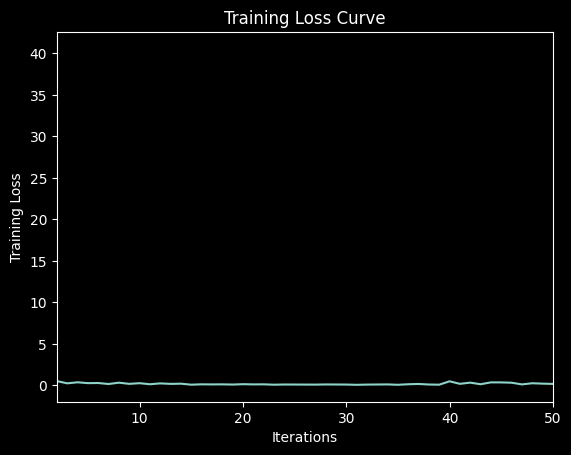

In [20]:
train_test_vae(epochs, complete_loader, model, optimizer)

In [21]:
def extract_latent_space(vae, data_loader):
    latent_space = []
    labels = []

    vae.eval()
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            mean, log_var = vae.encode(batch_data)
            z = vae.reparaterize(mean, log_var)
            latent_space.append(z.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(latent_space), labels

In [22]:
emo_pair_latent_space, labels = extract_latent_space(model, complete_loader)

In [23]:

emo_pair_vae_2d_tsne = TSNE(n_components=2, random_state=42)
emo_pair_latent_2d_tsne = emo_pair_vae_2d_tsne.fit_transform(emo_pair_latent_space)

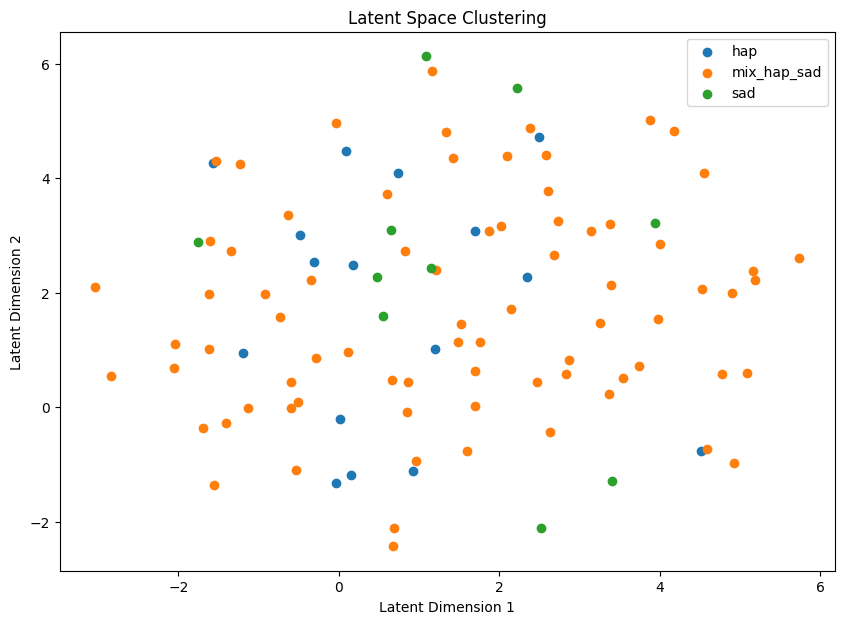

In [24]:
#2D
plt.style.use('default')
plt.figure(figsize=(10, 7))
for idx,label in enumerate(np.unique(labels)):
    plt.scatter(emo_pair_latent_2d_tsne[labels==label, 0], emo_pair_latent_2d_tsne[labels==label, 1], label=label_mapping[label])
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

plt.title('Latent Space Clustering')
plt.show()

In [25]:
label_mapping

{1: 'mix_hap_sad', 0: 'hap', 2: 'sad'}

In [26]:
labels = [str(element) for element in labels]
string_label_mapping = {"0": "hap", "1": "mix_hap_sad", "2": "sad"}

for i in range(len(labels)):
    labels[i] = string_label_mapping[labels[i]]

In [27]:
# 3D
emo_pair_vae_3d_tsne = TSNE(n_components=3, random_state=42, perplexity=20, learning_rate=10,n_iter=3000)
emo_pair_latent_3d_tsne = emo_pair_vae_3d_tsne.fit_transform(emo_pair_latent_space)

color_mapping = {'sad': '#205295', 'hap': '#FFD4B2', 'mix_hap_sad': '#EAE7B1'}

fig_mix_3d = px.scatter_3d(x=emo_pair_latent_3d_tsne[:, 0], y=emo_pair_latent_3d_tsne[:, 1], z=emo_pair_latent_3d_tsne[:, 2], color=labels, category_orders=label_mapping, color_discrete_map=color_mapping)

# Update the layout to adjust the axis labels and title
fig_mix_3d.update_layout(scene=dict(xaxis=dict(title='Latent Dim 1'),
                             yaxis=dict(title='Latent Dim 2'),
                             zaxis=dict(title='Latent Dim 3')),
                  #title='Latent Space Clustering for Disgust, Happiness and Their Mix',
                  width=600, height=500)

fig_mix_3d.update_layout(showlegend=True)


fig_mix_3d.show()


# t-SNE

In [28]:
single_emo = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/single_emo_facial_no_time_6.csv')
mix_emo = pd.read_csv('/Users/jiachenyao/Desktop/Thesis/Preprocessed_data/Mixed_emotions_noratio_notime_6.csv')

In [29]:
single_emo

,emotion,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,ang,0.034507,0.172575,-0.636632,-0.000907,0.423607,-0.681087,0.026812,0.329983,0.587189,...,-0.274848,-0.082332,0.247422,0.524098,0.384769,0.335507,-0.351378,-0.141354,1.412909,-0.257705
1,ang,0.033998,-0.180164,1.384301,-0.050094,-0.498916,1.378677,0.354679,-0.388865,-1.438841,...,-0.704516,-0.543308,-0.451960,-0.300291,-0.490040,-0.557027,1.415457,-0.721727,-0.620105,0.118530
2,ang,0.033026,0.151222,-0.642351,-0.010744,0.406572,-0.685773,0.019501,0.310415,0.552142,...,-0.380068,-0.121632,-0.069978,0.125823,0.265722,0.106912,-0.361294,-0.189015,1.105460,-0.480016
3,ang,0.033748,0.178484,-0.638921,-0.001827,0.463461,-0.673958,0.024830,0.353243,0.591314,...,-0.311510,-0.053467,0.205387,0.363770,0.387702,0.344406,-0.361294,-0.145641,1.477177,-0.304717
4,ang,0.036074,0.184641,-0.633593,0.006040,0.488670,-0.665909,0.031418,0.367705,0.617489,...,-0.178426,-0.004528,0.553215,0.881655,0.465150,0.589562,-0.361294,-0.041918,1.741711,-0.041769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,fea,0.047496,0.055906,1.350079,-0.031552,0.023227,1.343764,-0.305131,0.066955,-1.438822,...,-0.818811,-0.665598,-0.543886,2.614657,-0.619116,-0.559540,3.930724,-0.691104,0.162926,1.358905
1814,fea,0.027743,0.055613,-0.710175,-0.038520,0.136010,-0.715259,-0.008208,0.105172,0.609007,...,1.682735,2.313084,1.114296,-0.783975,-0.619116,0.203953,-0.361294,1.464886,-0.814698,-0.585195
1815,fea,0.029308,0.082567,-0.698607,-0.028502,0.222611,-0.705084,0.000609,0.155787,0.649684,...,2.027544,2.581375,1.406224,-0.783975,-0.619116,0.555087,-0.361294,1.872232,-0.335799,-0.585195
1816,fea,0.030959,0.144463,-0.672461,-0.022972,0.329800,-0.678018,0.005937,0.253681,0.671162,...,2.253383,2.760527,1.669166,-0.783975,-0.619116,0.842378,-0.361294,2.234318,-0.071264,-0.225833


In [30]:
mix_emo

,emotion,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,mix_disg_fea,0.209480,0.070330,0.025548,0.366800,0.923905,0.036992,0.837792,0.549997,0.764550,...,0.115394,0.061888,0.052818,0.047967,0.029825,0.059462,0.000382,0.003289,0.053472,0.017732
1,mix_disg_fea,0.217750,0.072206,0.796759,0.363637,0.925192,0.758143,0.828539,0.556800,0.000024,...,0.032794,0.039154,0.038003,0.047961,0.063054,0.038775,0.240407,0.157472,0.061306,0.150789
2,mix_disg_fea,0.209375,0.070076,0.004253,0.366691,0.923718,0.010992,0.837695,0.549042,0.741957,...,0.087006,0.023643,0.023992,0.013857,0.000000,0.032183,0.000000,0.000000,0.013175,0.000000
3,mix_disg_fea,0.209513,0.070220,0.010890,0.366798,0.923822,0.017176,0.837825,0.549537,0.761948,...,0.118394,0.070536,0.055169,0.048865,0.022072,0.063090,0.000000,0.000000,0.054455,0.000000
4,mix_disg_fea,0.209691,0.070583,0.043402,0.367108,0.924069,0.030644,0.838049,0.550713,0.785502,...,0.145377,0.084328,0.078391,0.073662,0.056553,0.088752,0.000000,0.006275,0.085196,0.004807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,mix_ang_disg,0.198816,0.070197,0.830224,0.366626,0.923686,0.808791,0.836908,0.549053,0.000009,...,0.007148,0.010157,0.059374,0.011227,0.013960,0.157379,0.054221,0.012730,0.048321,0.127149
5030,mix_ang_disg,0.209229,0.070575,0.014245,0.366760,0.924265,0.031781,0.837624,0.551245,0.701822,...,0.276620,0.170232,0.000000,0.079788,0.072063,0.000000,0.000000,0.124613,0.027930,0.000000
5031,mix_ang_disg,0.209284,0.070687,0.018281,0.366848,0.924330,0.037970,0.837710,0.551602,0.711801,...,0.294609,0.185206,0.023094,0.087519,0.084710,0.000000,0.011235,0.138040,0.042159,0.000000
5032,mix_ang_disg,0.209357,0.070743,0.020961,0.366958,0.924360,0.042608,0.837792,0.551761,0.715497,...,0.319022,0.201756,0.047856,0.096271,0.099982,0.004679,0.021287,0.146825,0.070089,0.009974


In [30]:
single_disg_fea_filtered = single_emo[(single_emo['emotion'] == 'disg') | (single_emo['emotion'] == 'fea')]
mix_disg_fea_filtered = mix_emo[mix_emo['emotion'] == 'mix_disg_fea']

disg_fea_notime = pd.concat([single_disg_fea_filtered, mix_disg_fea_filtered], ignore_index=True)
